# Clustering
### `! git clone https://www.github.com/ds4e/clustering`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Clustering
- The $k$-NN algorithm provided a simple tool for *regression* --- predicting numeric values for new data from existing data --- and *classification* --- predicting categorical values for new data from existing data
- That kind of algorithm is called a *supervised learning* algorithm, because we are telling the machine that success
- Today we are going to look at an *unsupervised learning* algorithm, in which we ask the machine to look for general patterns, without defining what success looks like in advance
- We're going to focus mainly on $k$-means clustering, but will mention a few other alternatives towards the end

## Unsupervised Learning
- Basically, we don't have a $y$: there's no single "outcome" that we are specifically trying to predict, like with regression or classification (supervised learning)
- Instead, we have data and are looking for meaningful patterns that we can use to conceptualize relationships between the variables in general
- Presumably, there is a **latent discrete structure** or **unobserved discrete heterogeneity** hidden with a categorical, discrete flavor in the data we are trying to recover

## Examples
- There are collusive bidders and competitive bidders in an auction, and we're trying to detect which are which by observing aspects of their behavior besides just the bid
- Many diseases (cancer, diabetes, etc.) have common underlying causes, but qualitatively different consequences from which different strains can be identified
- When looking for anomalies in data (cybersecurity, fraud, auditing), clustering can separate extreme cases from common ones and identify patterns of behavior that arouse suspicion (e.g. Benford's Law and cheating)
- We're going to use electricity consumption data for Virginia, divided into sectors: Industrial, Residential, Commercial, and Transportation

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/ashleynguyen04/clustering/refs/heads/main/data/electricity_data_validation.csv') # Load data
df.head() # First few rows

,Unnamed: 0,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,price-units,revenue-units,sales-units
0,0,2024-06,VA,Virginia,IND,industrial,3964.0,8.84,123.69650,1398.75048,number of customers,cents per kilowatthour,million dollars,million kilowatthours
1,1,2024-06,VA,Virginia,OTH,other,NaN,NaN,NaN,NaN,number of customers,cents per kilowatthour,million dollars,million kilowatthours
2,2,2024-06,VA,Virginia,RES,residential,3679257.0,15.31,650.42425,4248.38141,number of customers,cents per kilowatthour,million dollars,million kilowatthours
3,3,2024-06,VA,Virginia,ALL,all sectors,4135768.0,11.50,1378.52957,11984.50353,number of customers,cents per kilowatthour,million dollars,million kilowatthours
4,4,2024-06,VA,Virginia,TRA,transportation,1.0,9.62,1.60207,16.66045,number of customers,cents per kilowatthour,million dollars,million kilowatthours


In [ ]:
## Clean data:
sectors = ['industrial', 'residential', 'transportation', 'commercial']

# Keep those four sectors
keep = df['sectorName'].isin(sectors)  # Create keep sector indicator
df = df.loc[keep,['price','sales','sectorName']] # Use .loc to row filter the data

df = df.dropna(axis=0) # Drop missing values

df['sectorName'].value_counts()

,count
sectorName,
industrial,18
residential,18
transportation,18
commercial,18


## With Labels:
- This is the "true" labelling of the data:

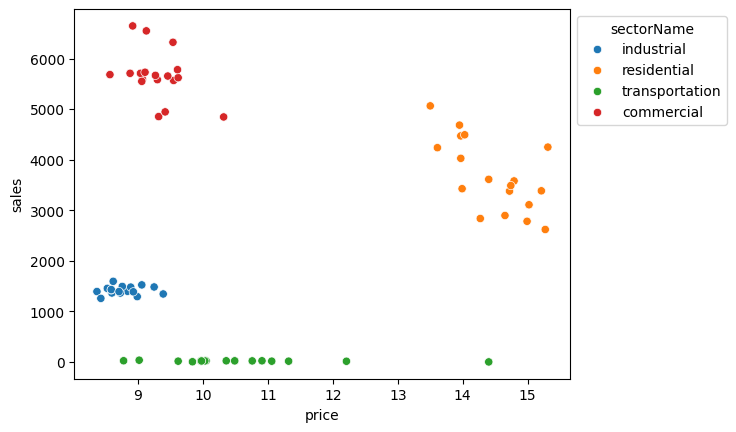

In [ ]:
this_plot = sns.scatterplot(x='price',y='sales',hue='sectorName',data=df)
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1))

## Without Labels:
- If the sector information is wiped away, some patterns still remain:

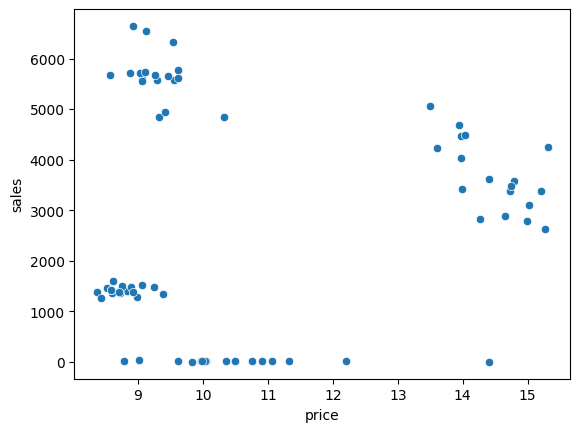

In [ ]:
this_plot = sns.scatterplot(x='price',y='sales',data=df)

## Unsupervised Learning
- Basically: "Can we recover the labels by examining the data, without knowing which group a point belongs to?"
- This is a conceptually simple problem, but it is a prototype for more general issues in recovering unobserved heterogeneity among observational units
- We'll be motivated by a simple idea, similar to $k$-NN: "If two points were created by the same data generating process/cluster, then their values are probably close together. If there are a discrete number of distinct data generating processes, we should be able to recover  their values by looking at separation between the groups."

## $k$-Means Clustering Algorithm ($k$-MC)
- The $k$-Means Clustering algorithm is:

  0. (Initialization) Randomly select $k$ points to be the *centroids*, $\{c_1, c_2, ..., c_k\}$
  1. Find the distance of each observation $x_i$ to each centroid $c_j$
  2. Assign each point $i$ to the closest centroid $j$
  3. Compute the new value of each centroid $j$ as the average of all of the observations $i$ assigned to it
  4. (Convergence) Repeat steps 1--3 until the observations are assigned to the same centroids twice, or a maximum number of iterations is reached

- $k$-MC is one of many clustering algorithms. What is nice about it is that, despite it being computationally intensive to calculate all these distances, it does scale to very large datasets. Likewise, a lot of the steps in using $k$-MC appear in other, similar algorithms (e.g. scree plot for spectral clustering)
- The next set of code chunks illustrate the algorithm for us

In [ ]:
from sklearn.cluster import KMeans # Import kmc

# Max-min scaler function:
def maxmin(x): # Max-min scaler function
    x = (x-min(x))/(max(x)-min(x))
    return x

# Create normalizations and add to the dataframe
min_x1 = min(df.loc[:,'price']) # I'm putting these aside to rescale values later
max_x1 = max(df.loc[:,'price'])
min_x2 = min(df.loc[:,'sales'])
max_x2 = max(df.loc[:,'sales'])

# Preprocess the data for scikit:
X = df.loc[ : , ['price','sales'] ] # Select data to cluster
X = X.apply(maxmin)
X.head()

,price,sales
0,0.067723,0.210339
2,1.000000,0.639332
4,0.180115,0.002274
5,0.168588,0.951309
6,0.056196,0.224621


Text(0.5, 1.0, 'The Data')

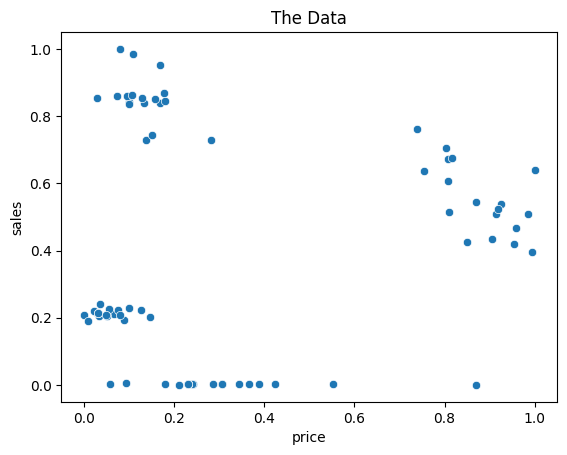

In [ ]:
sns.scatterplot(data=X,x='price',y='sales').set_title('The Data') # Plot the fake data

<Axes: title={'center': 'Iteration 1'}, xlabel='price', ylabel='sales'>

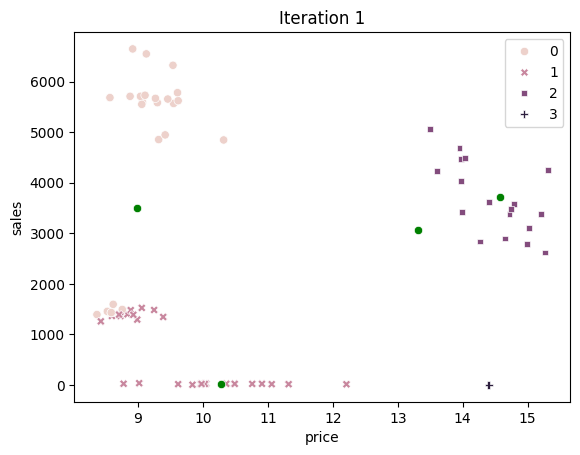

In [ ]:
from sklearn.cluster import KMeans # Import kmc

#np.random.seed(100) # Does not work
np.random.seed(10)
initial_centroids = np.random.randint(low=1,high=X.shape[0],size=4) # Determine initial centroids
model = KMeans(n_clusters=4, max_iter=1,
               init = X.iloc[initial_centroids,:],random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('Iteration 1')
sns.scatterplot( x=centroid_x_1, y=centroid_x_2, color='green')

<Axes: title={'center': 'Iteration 2'}, xlabel='price', ylabel='sales'>

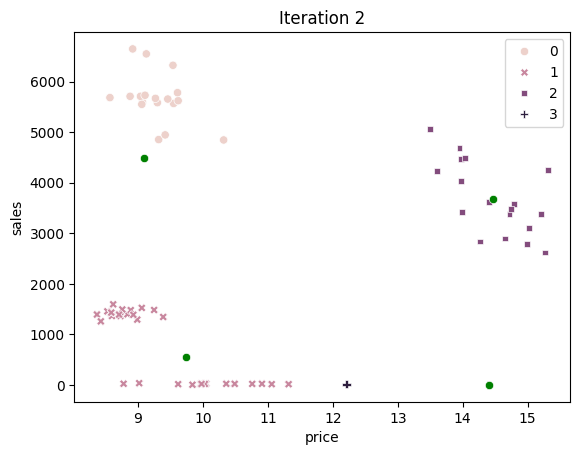

In [ ]:
np.random.seed(10)
initial_centroids = np.random.randint(low=1,high=X.shape[0],size=4) # Determine initial centroids
model = KMeans(n_clusters=4, max_iter=2,
               init = X.iloc[initial_centroids,:],random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('Iteration 2')
sns.scatterplot( x=centroid_x_1, y=centroid_x_2, color='green')

<Axes: title={'center': 'Iteration 3'}, xlabel='price', ylabel='sales'>

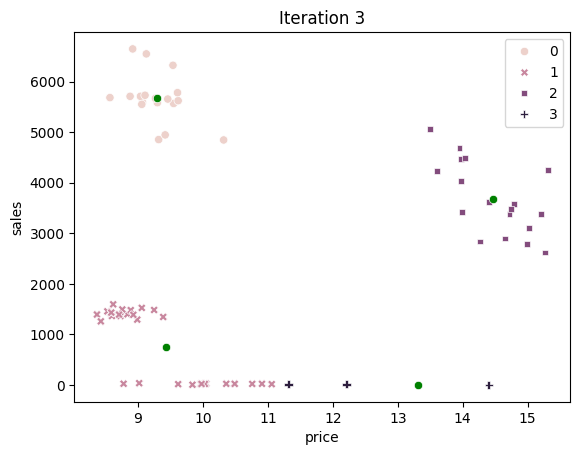

In [ ]:
np.random.seed(10)
initial_centroids = np.random.randint(low=1,high=X.shape[0],size=4) # Determine initial centroids
model = KMeans(n_clusters=4, max_iter=3,
               init = X.iloc[initial_centroids,:],random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('Iteration 3')
sns.scatterplot( x=centroid_x_1, y=centroid_x_2, color='green')

<Axes: title={'center': 'Iteration 4'}, xlabel='price', ylabel='sales'>

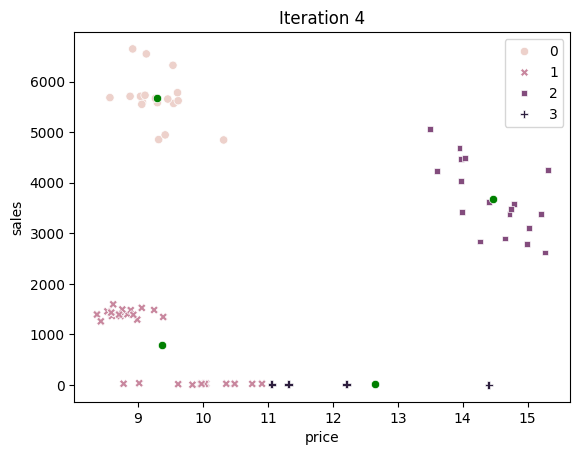

In [ ]:
np.random.seed(10)
initial_centroids = np.random.randint(low=1,high=X.shape[0],size=4) # Determine initial centroids
model = KMeans(n_clusters=4, max_iter=4,
               init = X.iloc[initial_centroids,:],random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('Iteration 4')
sns.scatterplot( x=centroid_x_1, y=centroid_x_2, color='green')

<Axes: title={'center': 'Iteration 5'}, xlabel='price', ylabel='sales'>

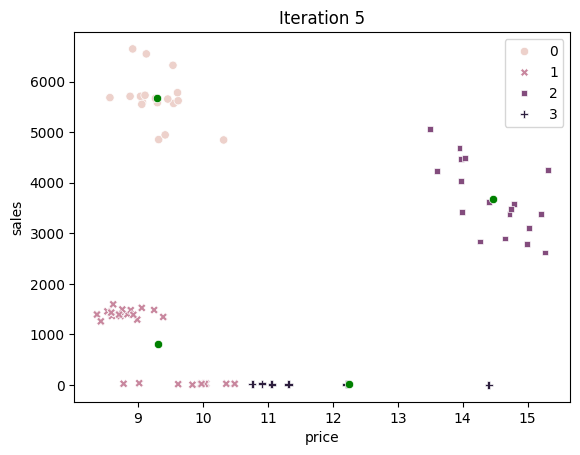

In [ ]:
np.random.seed(10)
initial_centroids = np.random.randint(low=1,high=X.shape[0],size=4) # Determine initial centroids
model = KMeans(n_clusters=4, max_iter=5,
               init = X.iloc[initial_centroids,:],random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('Iteration 5')
sns.scatterplot( x=centroid_x_1, y=centroid_x_2, color='green')

<Axes: title={'center': 'Iteration 6'}, xlabel='price', ylabel='sales'>

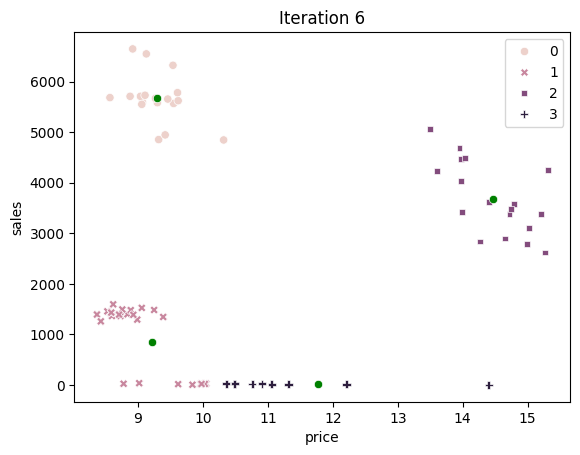

In [ ]:
np.random.seed(10)
initial_centroids = np.random.randint(low=1,high=X.shape[0],size=4) # Determine initial centroids
model = KMeans(n_clusters=4, max_iter=6,
               init = X.iloc[initial_centroids,:],random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('Iteration 6')
sns.scatterplot( x=centroid_x_1, y=centroid_x_2, color='green')

<Axes: title={'center': 'Iteration 7'}, xlabel='price', ylabel='sales'>

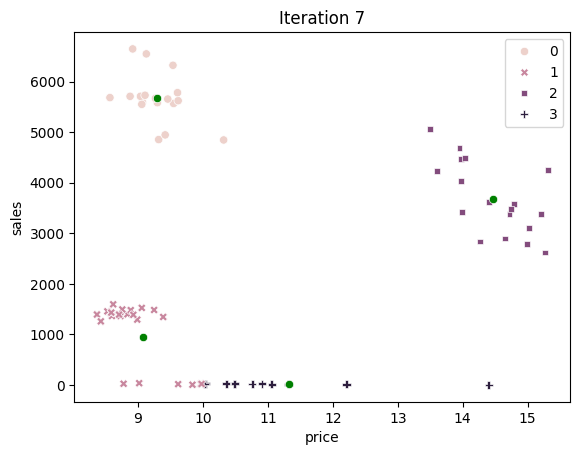

In [ ]:
np.random.seed(10)
initial_centroids = np.random.randint(low=1,high=X.shape[0],size=4) # Determine initial centroids
model = KMeans(n_clusters=4, max_iter=7,
               init = X.iloc[initial_centroids,:],random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('Iteration 7')
sns.scatterplot( x=centroid_x_1, y=centroid_x_2, color='green')

<Axes: title={'center': 'Iteration 9'}, xlabel='price', ylabel='sales'>

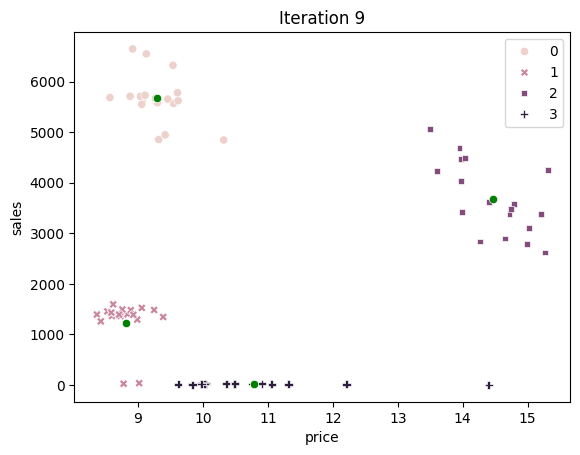

In [ ]:
np.random.seed(10)
initial_centroids = np.random.randint(low=1,high=X.shape[0],size=4) # Determine initial centroids
model = KMeans(n_clusters=4, max_iter=9,
               init = X.iloc[initial_centroids,:],random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('Iteration 9')
sns.scatterplot( x=centroid_x_1, y=centroid_x_2, color='green')

## Distance and Scaling
- As with $k$-NN, we typically mean Euclidean distance between each centroid $c_j = (c_{j1},c_{j2},...,c_{jL})$ and each observation $x_i=(x_{i1},x_{i2},...,x_{iL})$:
$$ d(c_j,x_i) = \sqrt{ \sum_{\ell=1}^L ( x_{i\ell} - c_{j\ell})^2} $$
- We also need to scale the variables, since the distance metric we're using is relatively arbitrary. We typically use maxmin to rescale each variable $ (x_{1\ell}, x_{2\ell}, ..., x_{N\ell})$:
$$ u_{i\ell} = \dfrac{x_{i\ell} - \min_i (x_{i\ell})}{\max_i (x_{i\ell})-\min_i(x_{i\ell})} $$
to ensure all of the dimensions are roughly comparable in magnitude
- There are dozens of variations on these pieces to be more data-driven or reconceptualize "distance" to be more appropriate for the current application

## SciKit
- There's a canned version of $k$ Means Clustering that can easily be imported:
    - `from sklearn.cluster import KMeans`
- Key arguments with preset values:
    1. `n_clusters = 3`: Number of clusters
    2. `n_init = 10`: How many test runs
    3. `max_iter = 300`: Maximum number of iterations of the $k$MC algorithm; how many times to start from step zero?
    4. `random_state = None`: An initial state for the random number generator for replicability
- To create and fit a $k$-MC model, you:
    1. Use `model = KMeans(n_clusters,n_init)` to create the model
    2. Use the `.fit(X)` method to fit the model to the data $X$
    3. Use the `.predict(X_hat)` method to predict cluster values for new cases `X_hat`

## Example
- With these example data, only two points gets misclassified: The transportation sector points on the bottom left of the plot
- This obviously depends on how well the data are "separated": If the groups aren't reasonably visually distinct, the algorithm is unlikely to magically fix that problem (but it might help a lot in higher dimensional situations, where you have trouble visualizing the groups)

<Axes: title={'center': 'Iteration 7'}, xlabel='price', ylabel='sales'>

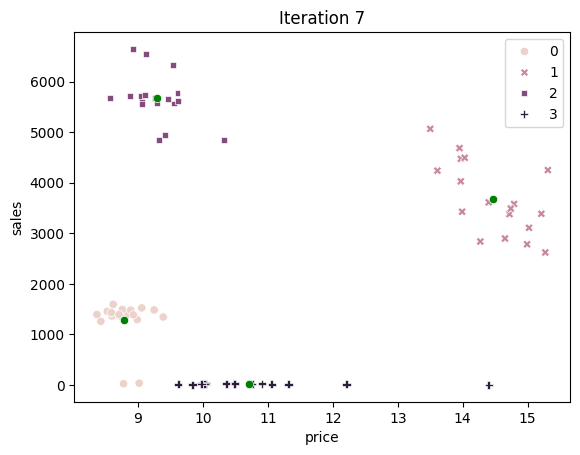

In [ ]:
model = KMeans(n_clusters=4,random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('Iteration 7')
sns.scatterplot( x=centroid_x_1, y=centroid_x_2, color='green')

## Greedy Algorithms
- This is an example of a *greedy algorithm*
- When you assign observations to clusters/centroids, you are ignoring the consequences of changing the centroid averages for overall optimality
- Because you're ignoring the consequences of changing the centroid averages, the optimal assignment might change
- This process might never converge, and just run endlessly, with points meaninglessly wandering back and forth between centroids
- In general, there is no guarantee a stable assignment of observations to centroids exists
- The algorithm is greedy because it is short-sighted about the consequences of its actions, and need not converge to an optimal outcome (some algorithms do achieve optimality, despite being greedy)
- The non-greedy version of $k$-means clustering is arguably something called the **EM Algorithm** for imputing missing data, or a Gaussian Mixture Model (GMM)


## Adjusting $k$
- Typically, you don't want to have "too many clusters"
- For me, "too many clusters" means that many initial guesses give similar results in terms of minimizing error, but the cluster assignments change a lot across these minimizers: "Too many clusters" means that the assignment is somewhat arbitrary, which defeats the point of the algorithm in some sense

<Axes: title={'center': 'k=2: Too Few'}, xlabel='price', ylabel='sales'>

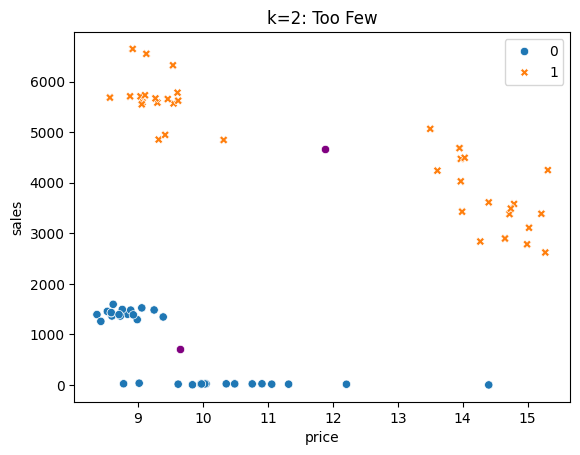

In [ ]:
model = KMeans(n_clusters=2,random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('k=2: Too Few')
sns.scatterplot( x=centroid_x_1, y=centroid_x_2, color='purple')

<Axes: title={'center': 'k=3: Too Few'}, xlabel='price', ylabel='sales'>

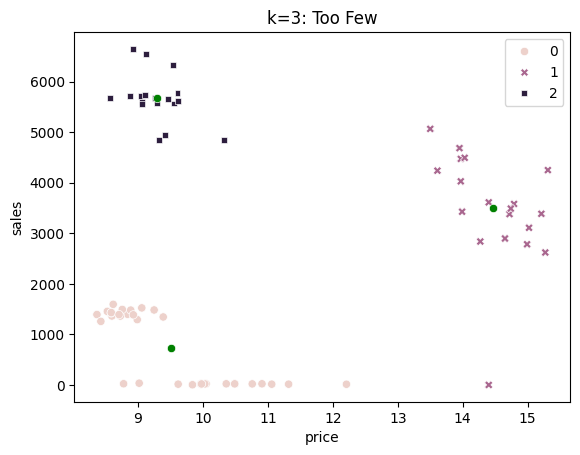

In [ ]:
model = KMeans(n_clusters=3,random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('k=3: Too Few')
sns.scatterplot( x=centroid_x_1, y=centroid_x_2, color='green')

<Axes: title={'center': 'k=4: Looks Good'}, xlabel='price', ylabel='sales'>

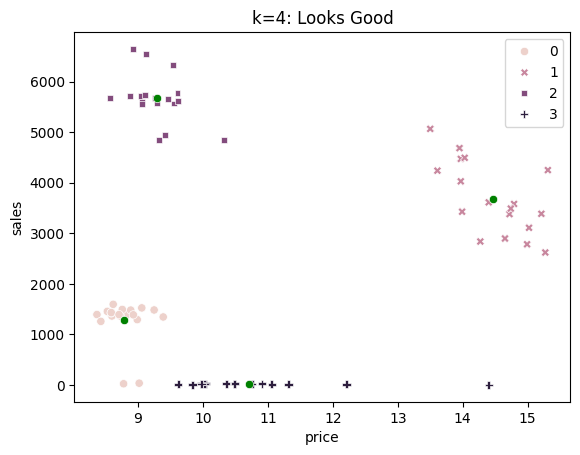

In [ ]:
model = KMeans(n_clusters=4,random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('k=4: Looks Good')
sns.scatterplot( x=centroid_x_1, y=centroid_x_2, color='green')

<Axes: title={'center': 'k=5: Competing Centroids'}, xlabel='price', ylabel='sales'>

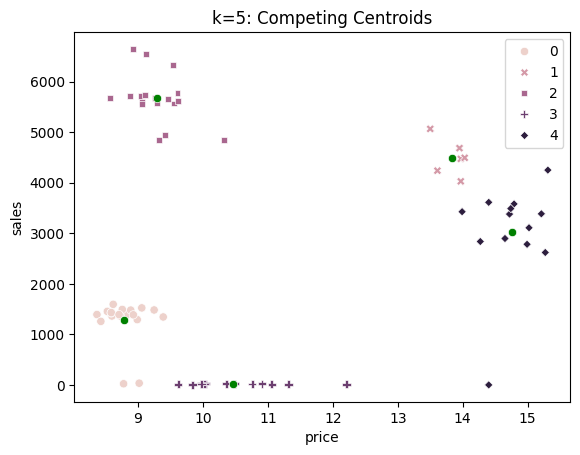

In [ ]:
model = KMeans(n_clusters=5,random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('k=5: Competing Centroids')
sns.scatterplot( x=centroid_x_1, y=centroid_x_2, color='green')

<Axes: title={'center': 'k=6: Competing Centroids'}, xlabel='price', ylabel='sales'>

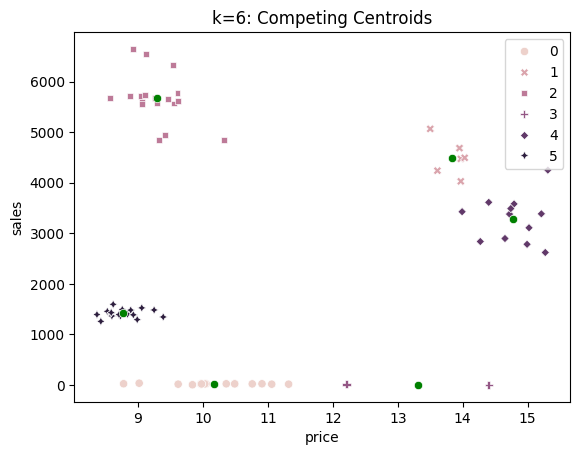

In [ ]:
model = KMeans(n_clusters=6,random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('k=6: Competing Centroids')
sns.scatterplot( x=centroid_x_1, y=centroid_x_2, color='green')


## Picking $k$
- The number of clusters $k$ is another hyper-parameter: Picking a higher $k$ will break the data up more and reduce the in-sample error, making it tempting to always add more clusters. Here's how most people handle this:
    1. For a range of reasonable values of $k$, compute the optimal centroids and the sum of squared error
    2. Create a **scree plot** that plots SSE as a function of $k$
    3. Pick a $k$ that strikes a balance between reducing the error but introducing too many clusters (an "elbow point"): The reduction in SSE of going from $k-1$ to $k$ clusters is much larger than going from $k$ to $k+1$ clusters

## Sum of Squared Error
- Fix $k$, and focus on the solution to the clustering problem
- Every cluster $j$ has a centroid $c_j$, and the distance from each observation $x_i$ to the centroid to which it is assigned is $d(x_i,c_j)$
- The *within cluster squared error* is
$$
W_j = \sum_{\text{All observations } i \text{ in cluster } j} d(x_i,c_j)^2,
$$
and the *sum of squared error* (SSE) is
$$
\sum_{\text{All clusters j}} W_j = \sum_{\text{All clusters j}} \quad \sum_{\text{All observations } i \text{ in cluster } j} d(x_i,c_j)^2
$$
- This is a traditional metric of how well the model "fits" the data we'll come back to frequently
- In principle, $k$MC is trying to minimize this, but it's a greedy algorithm, so doesn't always achieve the global minimum SSE
- In scikit, this is the  `.inertia_` attribute of a fitted model.
    - Dot what? Yeah, I know... I didn't pick it...

## The Scree Plot
- If we plot $SSE(k)$ against the number of clusters $k$, we can see how the addition or subtraction of a cluster affects this measure of overall fit
- This is called a **scree plot**, and we can use it to decide on a particular number of clusters $k$

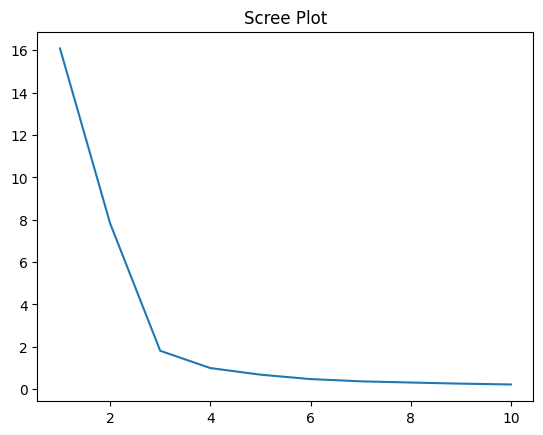

In [ ]:
from sklearn.cluster import KMeans # Import kmc

def maxmin(x): # Max-min scaler function
    x = (x-min(x))/(max(x)-min(x))
    return x

# Create a scree plot:
k_bar = 10
SSE = [] # We'll store the training error here
for k in range(k_bar): # For indices from 0 to k_bar-1
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0) # Create a model for k
    model = model.fit(X) # Fit the model
    SSE.append(model.inertia_) # Record the sum of squared error for k in the SSE vector

scree_plot = sns.lineplot(x=np.arange(1,k_bar+1), y=SSE).set_title('Scree Plot') # Create scree plot

## Elbows
- To decide on an optimal $k^*$, people look for a spot where the reduction in $SSE$ of going from $k-1$ to $k$ drops significantly compared from $k$ to $k+1$
- This means the *marginal benefit* of an additional cluster is small, and increasing $k$ further is probably not really improving the fit
- If there's no elbow, either
    1. There aren't really any discrete clusters, and you're approximating a continuous trend with the groups
    2. Maybe there are discrete clusters, but you need to do more feature engineering/transformations, like Principal Components Analysis, or use use a different algorithm/metric of error size (e.g. silhouette and gap statistic)
- In our electricity example, if you went entirely data driven, you'd lump Industrial and Transportation into one second. Maybe that's OK.
- This feels very subjective, and there are other, more quantitative approaches to this (e.g. silhouette, gap)

## Agglomerative/Hierarchical Clustering
- One easy and useful alternative to $k$-MC is **Hierarchical Clustering** or **Agglomerative Clustering**:

    0. All observations start in their own cluster
    1. Find the two "closest" clusters and merge them into a new cluster (this is conceptually a challenge, since the idea of "closest" becomes ambiguous when thinking about sets of points)
    2. Repeat until only one cluster remains

- Regardless of the dimension of the clustering variables, we can represent the clustering scheme using a **dendrogram** that shows how the observations are consistently grouped together at various levels of "resolution"
- This typically yields a more stable clustering scheme, but is much more computationally intensive; this is my favorite kind of clustering but it's rarely feasible


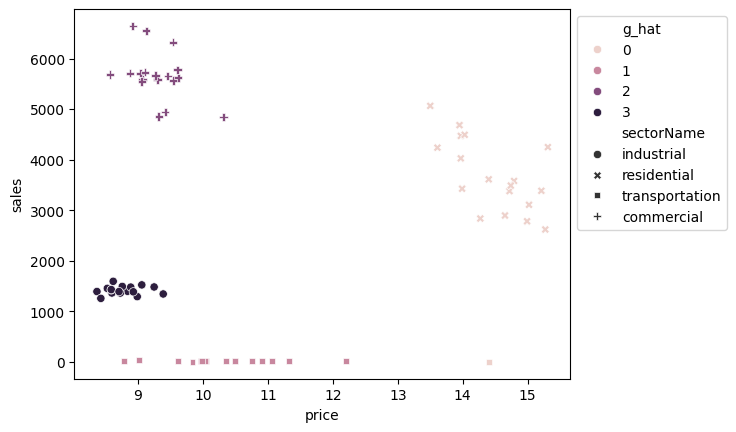

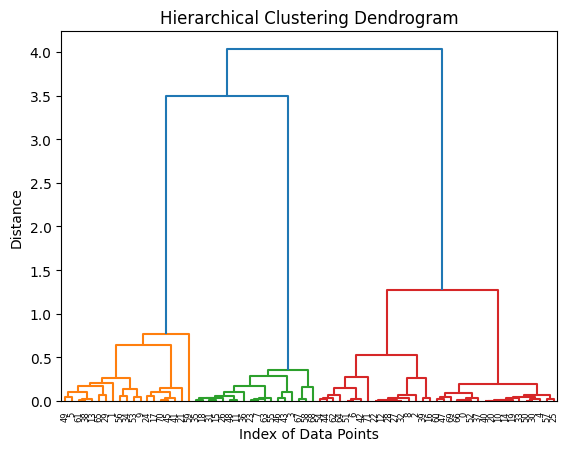

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

## Perform hierarchical clustering:
model = AgglomerativeClustering(n_clusters=4, linkage='ward') # Hierarchical clustering algorithm
model.fit(X)
df['g_hat'] = model.labels_ # Get predicted labels
this_plot = sns.scatterplot(x='price',y='sales',data=df, hue='g_hat',style='sectorName') # Scatterplot of the clustering
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1))
plt.show()

## Plot dendrogram:
plt.figure()
Z = linkage(X, 'ward') # Determine cluster membership
dendrogram(Z,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True) # Create dendrogram

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index of Data Points')
plt.ylabel('Distance')
plt.show()

## Distance Between Sets
- How do you determine the distance between two sets $A$ and $B$? This is a harder question than it might seem.
- The **maximum distance** is given by
$$
d(A,B) = \max_{\text{ $x$ in set $A$, $y$ in set $B$}} d(x,y) = \max_{\text{ $x$ in set $A$, $y$ in set $B$}} \sqrt{ \sum_{\ell = 1}^L (x_\ell - y_\ell)^2 }
$$
This is computationally intensive but straightforward, but can lead to counterintuitive results
- The **minimum distance** is given by
$$
d(A,B) = \min_{\text{ $x$ in set $A$, $y$ in set $B$}} d(x,y) = \min_{\text{ $x$ in set $A$, $y$ in set $B$}} \sqrt{ \sum_{\ell = 1}^L (x_\ell - y_\ell)^2 }
$$
If the sets $A$ and $B$ are "separated", this can be a good choice, but can likewise lead to counterintuitive results
- We could instead focus on the squared distance between the centroids $c_A$ and $c_B$ of the sets $A$ and $B$, respectively,
$$
d(A,B) = \sum_{\ell =1 }^L \left(  c_{A\ell} - c_{B\ell} \right)^2
$$
- Often the **Ward Linkage** is used,
$$
d(A,B) = \dfrac{|A| \times |B|}{|A \cup B|}\sum_{\ell =1 }^L \left(  c_{A\ell} - c_{B\ell} \right)^2
$$
where $|S|$ is the number of elements in the set $S$. This weights the distances by size to keep the agglomeration process consistent.
- There are dozens more of these, but Ward is often a default.

## Example: Crime by State, 2014

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

df = pd.read_csv('https://raw.githubusercontent.com/ashleynguyen04/clustering/refs/heads/main/data/crimebystatecombinedwithunemployment.csv')
df = df.loc[df['year']==2014,:]
df.head()

,state,unemployment,year,Population,violent total,Murder,rape,Robbery,Aggravated assault,property total,Burglary,Larceny theft,vehicle theft
38,AL,6.783,2014,4849377,427.4,5.7,29.6,96.9,283.4,3177.6,819.0,2149.5,209.1
77,AK,6.875,2014,736732,635.8,5.6,75.3,85.4,440.2,2760.0,427.6,2096.4,236.0
116,AZ,6.783,2014,6731484,399.9,4.7,36.6,92.8,252.1,3197.5,647.1,2289.1,261.3
155,AR,6.025,2014,2966369,480.1,5.6,39.8,69.1,346.0,3338.0,835.7,2313.5,188.8
194,CA,7.500,2014,38802500,396.1,4.4,21.6,125.5,236.6,2441.1,522.3,1527.4,391.3


In [ ]:
## Prepare data for clustering:

def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return z

#['Population','unemployment','violent total','Murder','property total'] # Available vars
vars =  ['property total','violent total']

X = df.loc[:,vars]
X = X.apply(maxmin)

X.describe()

,property total,violent total
count,51.000000,51.000000
mean,0.294990,0.231513
std,0.185493,0.156365
min,0.000000,0.000000
25%,0.140756,0.140512
50%,0.274924,0.198411
75%,0.404759,0.286482
max,1.000000,1.000000


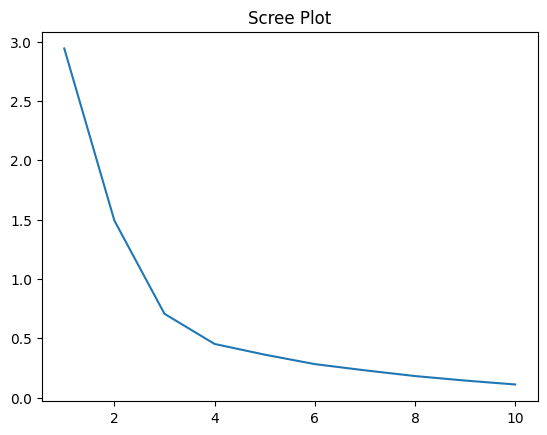

In [ ]:
## Scree plot:
k_bar = 10
SSE = [] # We'll store the training error here
for k in range(k_bar): # For indices from 0 to k_bar-1
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0) # Create a model for k
    model = model.fit(X) # Fit the model
    SSE.append(model.inertia_) # Record the sum of squared error for k in the SSE vector
scree_plot = sns.lineplot(x=np.arange(1,k_bar+1), y=SSE).set_title('Scree Plot') # Create scree plot

<Axes: xlabel='property total', ylabel='violent total'>

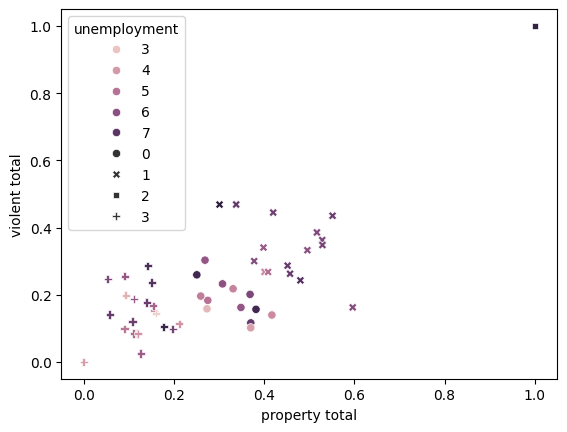

In [ ]:
## Optimal clustering:
kstar = 4
model = KMeans(n_clusters=kstar, max_iter=300, n_init = 10, random_state=0) # Create a model for k
model = model.fit(X) # Fit the model
g_hat = model.predict(X)
df['g_hat'] = g_hat
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], hue=df['unemployment'], style =g_hat)

## Examining the groups
- It's nice to actually look at the groups and see who is with whom:

In [ ]:
df.loc[g_hat==2,:] # Our nation's capitol - highest crime rate, pretty high unemployment

,state,unemployment,year,Population,violent total,Murder,rape,Robbery,Aggravated assault,property total,Burglary,Larceny theft,vehicle theft,g_hat
350,DC,7.775,2014,658893,1244.4,15.9,53.4,530.7,626.1,5182.5,526.0,4082.3,574.1,2


In [ ]:
df.loc[g_hat==1,:] # Roughly the south - highest crime rate after DC

,state,unemployment,year,Population,violent total,Murder,rape,Robbery,Aggravated assault,property total,Burglary,Larceny theft,vehicle theft,g_hat
38,AL,6.783,2014,4849377,427.4,5.7,29.6,96.9,283.4,3177.6,819.0,2149.5,209.1,1
77,AK,6.875,2014,736732,635.8,5.6,75.3,85.4,440.2,2760.0,427.6,2096.4,236.0,1
116,AZ,6.783,2014,6731484,399.9,4.7,36.6,92.8,252.1,3197.5,647.1,2289.1,261.3,1
155,AR,6.025,2014,2966369,480.1,5.6,39.8,69.1,346.0,3338.0,835.7,2313.5,188.8,1
311,DE,5.717,2014,935614,489.1,5.8,26.6,135.6,306.4,2982.0,616.5,2230.1,135.4,1
389,FL,6.283,2014,19893297,540.5,5.8,30.4,125.2,366.4,3415.5,719.9,2481.5,214.0,1
428,GA,7.092,2014,10097343,377.3,5.7,21.4,123.0,218.4,3281.2,756.9,2258.4,266.0,1
740,LA,6.367,2014,4649676,514.7,10.3,21.3,122.5,352.4,3458.8,824.5,2421.6,212.7,1
1013,MO,6.133,2014,6063589,442.9,6.6,28.1,92.2,304.8,2906.5,581.5,2055.3,269.8,1
1130,NV,7.925,2014,2839099,635.6,6.0,35.0,209.7,372.1,2625.4,772.3,1494.3,358.7,1


In [ ]:
df.loc[g_hat==2,:] # Roughly the midwest and New England - lowest crime rates

In [ ]:
df.loc[g_hat==3,:] # Roughly the midwest and New England

,state,unemployment,year,Population,violent total,Murder,rape,Robbery,Aggravated assault,property total,Burglary,Larceny theft,vehicle theft,g_hat
272,CT,6.617,2014,3596677,236.9,2.4,15.9,87.8,125.0,1920.4,332.4,1418.1,169.9,3
506,ID,4.842,2014,1634464,212.2,2.0,28.6,12.5,160.5,1854.8,393.3,1359.9,101.6,3
545,IL,7.092,2014,12880580,370.0,5.3,23.9,118.8,213.7,2075.9,388.2,1552.2,135.5,3
623,IA,4.242,2014,3107126,273.5,1.9,26.6,33.6,201.6,2093.8,464.4,1495.8,133.6,3
701,KY,6.458,2014,4413457,211.6,3.6,20.0,75.6,99.8,2246.9,526.7,1577.1,143.2,3
779,ME,5.625,2014,1330089,127.8,1.6,27.1,22.9,66.9,1986.4,378.2,1548.2,60.1,3
857,MA,5.750,2014,6745408,391.4,2.0,24.1,89.5,267.6,1857.1,370.1,1364.5,122.5,3
896,MI,7.250,2014,9909877,427.3,5.4,40.9,80.9,277.7,2043.9,445.9,1384.5,213.5,3
935,MN,4.158,2014,5457173,229.1,1.6,26.6,67.6,123.3,2297.5,380.7,1763.5,153.3,3
1169,NH,4.275,2014,1326813,196.1,0.9,34.5,40.5,110.0,1962.7,313.7,1584.4,64.6,3


## Group Statistics
- Another nice way to investigate or summarize the clustering is to describe the groups by/conditional on their assignment
- We can use the `.groupby('g_hat').describe()` method to organize the calculations by group

In [ ]:
df.loc[:,['g_hat','property total','violent total']].groupby('g_hat').describe()

property total                                                      \
               count         mean         std     min       25%      50%   
g_hat                                                                      
0               13.0  2712.353846  202.610178  2441.1  2523.500  2735.20   
1               16.0  3182.618750  297.666326  2625.4  2988.525  3187.55   
2                1.0  5182.500000         NaN  5182.5  5182.500  5182.50   
3               21.0  1972.076190  181.093812  1524.4  1863.900  1964.70   

                        violent total                                   \
            75%     max         count         mean         std     min   
g_hat                                                                    
0      2878.500  3050.0          13.0   313.023077   65.167811   215.6   
1      3426.325  3706.1          16.0   483.993750  101.252124   285.2   
2      5182.500  5182.5           1.0  1244.400000         NaN  1244.4   
3      2088.300  2297.5          21.0   263.195238   85.326616    99.3   

                                           
            25%     50%       75%     max  
g_hat                                      
0       278.500   309.1   348.600   446.1  
1       405.975   484.6   554.725   635.8  
2      1244.400  1244.4  1244.400  1244.4  
3       211.600   261.2   314.100   427.3

In [ ]:
df.loc[:,['g_hat','unemployment','violent total']].groupby('g_hat').describe() #those with lowest employment appear to have lowest crime rates

unemployment                                                          \
             count      mean       std    min    25%     50%    75%    max   
g_hat                                                                        
0             13.0  5.485308  1.345276  3.275  4.525  5.8000  6.308  7.500   
1             16.0  6.336937  0.794216  4.492  6.100  6.4085  6.783  7.925   
2              1.0  7.775000       NaN  7.775  7.775  7.7750  7.775  7.775   
3             21.0  5.447667  1.382665  2.675  4.242  5.6250  6.617  7.692   

      violent total                                                     \
              count         mean         std     min       25%     50%   
g_hat                                                                    
0              13.0   313.023077   65.167811   215.6   278.500   309.1   
1              16.0   483.993750  101.252124   285.2   405.975   484.6   
2               1.0  1244.400000         NaN  1244.4  1244.400  1244.4   
3              21.0   263.195238   85.326616    99.3   211.600   261.2   

                         
            75%     max  
g_hat                    
0       348.600   446.1  
1       554.725   635.8  
2      1244.400  1244.4  
3       314.100   427.3

In [ ]:
df.loc[:,['g_hat','unemployment','property total']].groupby('g_hat').describe()

unemployment                                                          \
             count      mean       std    min    25%     50%    75%    max   
g_hat                                                                        
0             13.0  5.485308  1.345276  3.275  4.525  5.8000  6.308  7.500   
1             16.0  6.336937  0.794216  4.492  6.100  6.4085  6.783  7.925   
2              1.0  7.775000       NaN  7.775  7.775  7.7750  7.775  7.775   
3             21.0  5.447667  1.382665  2.675  4.242  5.6250  6.617  7.692   

      property total                                                      \
               count         mean         std     min       25%      50%   
g_hat                                                                      
0               13.0  2712.353846  202.610178  2441.1  2523.500  2735.20   
1               16.0  3182.618750  297.666326  2625.4  2988.525  3187.55   
2                1.0  5182.500000         NaN  5182.5  5182.500  5182.50   
3               21.0  1972.076190  181.093812  1524.4  1863.900  1964.70   

                         
            75%     max  
g_hat                    
0      2878.500  3050.0  
1      3426.325  3706.1  
2      5182.500  5182.5  
3      2088.300  2297.5

## Agglomerative Clustering
- In this case, I don't think the agglomerative clustering adds much to the analysis, but it's easy to do:

g_hat
0    29
1    21
2     1
Name: count, dtype: int64


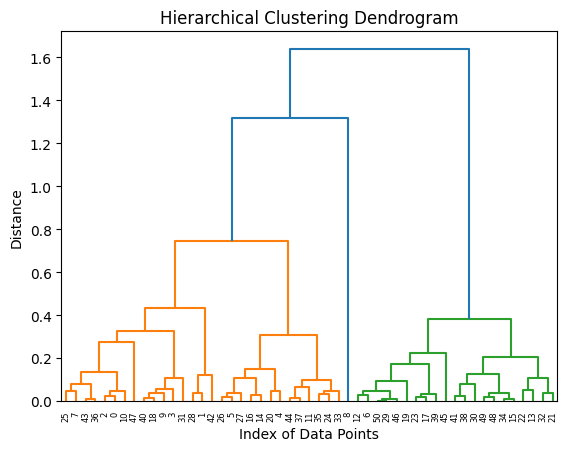

In [ ]:
model = AgglomerativeClustering(n_clusters=3, linkage='ward') #3 clusters!
model.fit(X)
g_hat = model.labels_
df['g_hat'] = model.labels_

print(df['g_hat'].value_counts())

# Plot dendrogram
plt.figure()
Z = linkage(X, 'ward')
dendrogram(Z,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index of Data Points')
plt.ylabel('Distance')
plt.show()

- Do you see Washington, DC? - the one blue line at index of data points 8

## Conclusion
- Clustering in many dimensions (say, greater than 5) is risky: When the number of dimensions gets larger, many dimensions probably contain similar information, and the redundant information gets over-weighted in the algorithm
    - In high dimensions, you'll probably want to use something called **Principal Components Analysis** to remove the common information from the features and facilitate visualization
- There are other versions (spectral, dbscan, OPTICS, ...) that fix various shortcomings of $k$-MC, but they are much more complex and computationally expensive; there is a conservation of misery
- Clustering is usually a mean to an end: The clustering is to push the data to reveal some latent group structure, and then that latent group structure enters into some other analysis